# Adapted from

https://github.com/Project-MONAI/tutorials/blob/main/modules/transfer_mmar.ipynb

In [24]:
# !pip install monai
# !python -c "import monai" || pip install -q "monai-weekly[nibabel, lmdb, tqdm]"

In [25]:
import os, sys, shutil, time, pickle, glob
from pathlib import Path

# numpy to SITK conversion
import torch
import numpy     as np
import SimpleITK as sitk

# hardware stats
import GPUtil as GPU

# plot
from helpers.viz import viz_axis, viz_compare_inputs, viz_compare_outputs
from helpers.viz import *

import matplotlib.pyplot as plt

# MONAI
from monai.networks.nets import UNet
from monai.losses import DiceFocalLoss
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.data import (
    Dataset,
    CacheDataset,
    LMDBDataset,
    DataLoader,
    decollate_batch,
)

from monai.networks.utils import copy_model_state
from monai.optimizers import generate_param_groups

from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    CenterSpatialCropd,
    EnsureChannelFirstd,
    Compose,
    LoadImaged,
    PadListDataCollate,
    ScaleIntensityRanged,
    Spacingd,
    SpatialPadd,
    Orientationd,
    CropForegroundd,
    RandCropByPosNegLabeld,
    RandAffined,
    RandRotated,
    EnsureType,
    EnsureTyped,
    ToTensord,
)

%matplotlib inline


# Get labels

In [26]:
root = "/home/gologors/data/"

with open(root + 'pitmri/' + 'all_filenames_pt.pkl', 'rb') as f: 
    all_filenames = pickle.load(f)
    
# Split into training/valid and testing 
# adapted from https://github.com/Project-MONAI/tutorials/blob/main/modules/autoencoder_mednist.ipynb

test_frac = 0.2
valid_frac = 0.2

num_test  = int(len(all_filenames) * test_frac)
num_valid = int(len(all_filenames) * valid_frac)
num_train = len(all_filenames) - num_test - num_valid

train_datadict = [{"im": nii, "lbl":obj} for nii,obj in all_filenames[:num_train]]
valid_datadict = [{"im": nii, "lbl":obj} for nii,obj in all_filenames[num_train:num_train+num_valid]]
test_datadict = [{"im": nii, "lbl": obj} for nii,obj in all_filenames[-num_test:]]

print(f"total number of images: {len(all_filenames)}")
print(f"number of images for training: {len(train_datadict)}")
print(f"number of images for val: {len(valid_datadict)}")
print(f"number of images for testing: {len(test_datadict)}")

total number of images: 50
number of images for training: 30
number of images for val: 10
number of images for testing: 10


In [27]:
# Shapes
all_shapes = []
for im_fn, lbl_fn in all_filenames:
    lbl_pt = torch.load(lbl_fn)
    all_shapes.append(tuple(lbl_pt.shape))
    print(lbl_pt.shape)

torch.Size([512, 512, 16])
torch.Size([320, 320, 14])
torch.Size([512, 512, 18])
torch.Size([512, 512, 14])
torch.Size([432, 432, 24])
torch.Size([256, 256, 24])
torch.Size([512, 512, 17])
torch.Size([256, 256, 11])
torch.Size([512, 512, 16])
torch.Size([432, 432, 18])
torch.Size([512, 512, 18])
torch.Size([512, 512, 16])
torch.Size([512, 512, 16])
torch.Size([300, 384, 15])
torch.Size([512, 512, 16])
torch.Size([336, 336, 14])
torch.Size([512, 512, 17])
torch.Size([512, 512, 18])
torch.Size([512, 512, 16])
torch.Size([576, 640, 17])
torch.Size([256, 256, 11])
torch.Size([512, 512, 20])
torch.Size([512, 512, 18])
torch.Size([512, 512, 16])
torch.Size([512, 512, 25])
torch.Size([512, 512, 18])
torch.Size([448, 448, 14])
torch.Size([336, 336, 14])
torch.Size([512, 512, 16])
torch.Size([432, 432, 18])
torch.Size([384, 384, 13])
torch.Size([512, 512, 12])
torch.Size([432, 432, 22])
torch.Size([400, 400, 42])
torch.Size([288, 288, 20])
torch.Size([512, 512, 15])
torch.Size([256, 256, 17])
t

In [28]:
print("Shapes of tensors")

print("Dim 0")
print(min(all_shapes, key=lambda s: s[0]))
print(max(all_shapes, key=lambda s: s[0]))

print("Dim 1")
print(min(all_shapes, key=lambda s: s[1]))
print(max(all_shapes, key=lambda s: s[1]))

print("Dim 2")
print(min(all_shapes, key=lambda s: s[2]))
print(max(all_shapes, key=lambda s: s[2]))

Shapes of tensors
Dim 0
(256, 256, 24)
(576, 640, 17)
Dim 1
(256, 256, 24)
(576, 640, 17)
Dim 2
(336, 336, 7)
(400, 400, 42)


# Transforms

In [29]:
largest_sz         = (576, 640, 42)
largest_sz         = (576, 640, 96)
center_crop_sz     = (288, 288, 96)

In [30]:
def load_pt(x):
    d = {}
    # do stuff to image
    for key, val in x.items():
        d[key] = torch.load(val)
    return d

In [31]:
# Transforms

train_transforms = Compose(
    [
        load_pt,
        AddChanneld(keys=["im", "lbl"]),
        SpatialPadd(keys=["im", "lbl"], spatial_size=largest_sz, method="symmetric", mode="constant"),
        CenterSpatialCropd(keys=["im", "lbl"], roi_size=center_crop_sz),
    ]
)

valid_transforms = train_transforms

In [32]:
check_ds = Dataset(data= [{"im": nii, "lbl": obj} for nii,obj in all_filenames], transform=valid_transforms)
check_loader = DataLoader(check_ds, batch_size=1)

image shape: torch.Size([288, 288, 96]), label shape: torch.Size([288, 288, 96])


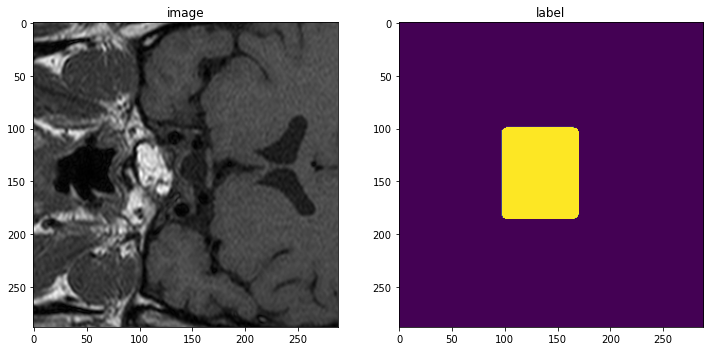

image shape: torch.Size([288, 288, 96]), label shape: torch.Size([288, 288, 96])


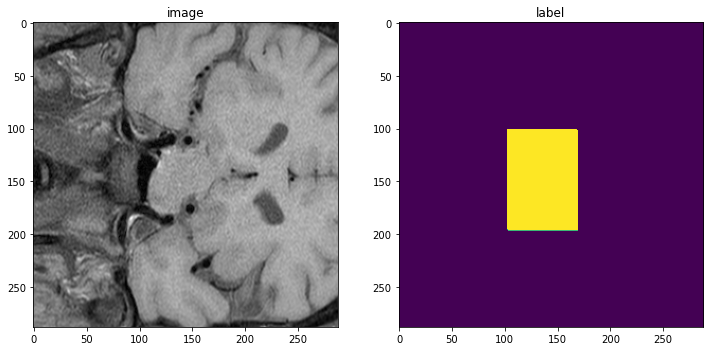

image shape: torch.Size([288, 288, 96]), label shape: torch.Size([288, 288, 96])


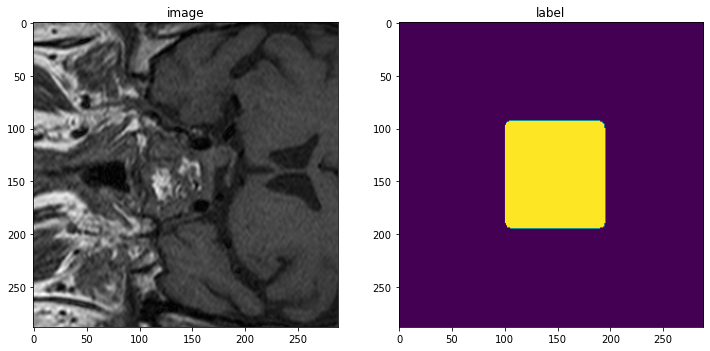

In [33]:
count_ims = 0
for check_data in check_loader:
    image, label = (check_data["im"][0][0], check_data["lbl"][0][0])
    print(f"image shape: {image.shape}, label shape: {label.shape}")
    # plot the slice [:, :, 21]
    plt.figure("check", (12, 6))
    plt.subplot(1, 2, 1)
    plt.title("image")
    plt.imshow(image[:, :, center_crop_sz[2]//2], cmap="gray")
    plt.subplot(1, 2, 2)
    plt.title("label")
    plt.imshow(label[:, :, center_crop_sz[2]//2])
    plt.show()
    
    count_ims += 1
    
    if count_ims == 3:
        break

In [34]:
train_ds = Dataset(data=train_datadict, transform=train_transforms)
valid_ds = Dataset(data=valid_datadict, transform=valid_transforms)

# train_ds = CacheDataset(data=train_datadict, transform=train_transforms, cache_rate=1.0, num_workers=2)
# valid_ds = CacheDataset(data=valid_datadict, transform=valid_transforms, cache_rate=1.0, num_workers=2)

In [35]:
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_ds, batch_size=2, shuffle=True, num_workers=2)

This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


In [36]:
# clear cache
torch.cuda.empty_cache()

from helpers.general import print_hardware_stats
print_hardware_stats()

#GPU = 1, #CPU = 16
GPU NVIDIA TITAN V       RAM Free: 12062MB | Used: 4MB | Util   0% | Total 12066MB


In [37]:
PRETRAINED = True

unet_path = f"/home/gologors/pitmri/PituitaryGenerator/unet/model.pth"
checkpoint = torch.load(unet_path)

In [38]:
print(checkpoint.keys())
print(checkpoint["opt"].keys())

dict_keys(['model', 'opt'])
dict_keys(['state', 'hypers'])


In [39]:
# UNET model
model = UNet(
                    dimensions=3,
                    in_channels=1,
                    out_channels=2,
                    channels=(16, 32, 64, 128, 256),
                    strides=(2, 2, 2, 2),
                    num_res_units=2,
                    dropout=0.0,
                )

In [40]:
from torchsummary import summary

In [41]:
center_crop_sz

(288, 288, 96)

In [42]:
summary(model.cuda(), (1,*center_crop_sz))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1     [-1, 16, 144, 144, 48]             448
            Conv3d-2     [-1, 16, 144, 144, 48]             448
    InstanceNorm3d-3     [-1, 16, 144, 144, 48]               0
           Dropout-4     [-1, 16, 144, 144, 48]               0
             PReLU-5     [-1, 16, 144, 144, 48]               1
            Conv3d-6     [-1, 16, 144, 144, 48]           6,928
    InstanceNorm3d-7     [-1, 16, 144, 144, 48]               0
           Dropout-8     [-1, 16, 144, 144, 48]               0
             PReLU-9     [-1, 16, 144, 144, 48]               1
     ResidualUnit-10     [-1, 16, 144, 144, 48]               0
           Conv3d-11       [-1, 32, 72, 72, 24]          13,856
           Conv3d-12       [-1, 32, 72, 72, 24]          13,856
   InstanceNorm3d-13       [-1, 32, 72, 72, 24]               0
          Dropout-14       [-1, 32, 72,

In [43]:
print(model)

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Se

In [44]:
checkpoint["model"].keys()

odict_keys(['model.0.conv.unit0.conv.weight', 'model.0.conv.unit0.conv.bias', 'model.0.conv.unit0.adn.A.weight', 'model.0.conv.unit1.conv.weight', 'model.0.conv.unit1.conv.bias', 'model.0.conv.unit1.adn.A.weight', 'model.0.residual.weight', 'model.0.residual.bias', 'model.1.submodule.0.conv.unit0.conv.weight', 'model.1.submodule.0.conv.unit0.conv.bias', 'model.1.submodule.0.conv.unit0.adn.A.weight', 'model.1.submodule.0.conv.unit1.conv.weight', 'model.1.submodule.0.conv.unit1.conv.bias', 'model.1.submodule.0.conv.unit1.adn.A.weight', 'model.1.submodule.0.residual.weight', 'model.1.submodule.0.residual.bias', 'model.1.submodule.1.submodule.0.conv.unit0.conv.weight', 'model.1.submodule.1.submodule.0.conv.unit0.conv.bias', 'model.1.submodule.1.submodule.0.conv.unit0.adn.A.weight', 'model.1.submodule.1.submodule.0.conv.unit1.conv.weight', 'model.1.submodule.1.submodule.0.conv.unit1.conv.bias', 'model.1.submodule.1.submodule.0.conv.unit1.adn.A.weight', 'model.1.submodule.1.submodule.0.resid

In [45]:
# copy all the pretrained weights except for variables whose name matches "model.0.conv.unit0"
pretrained_dict, updated_keys, unchanged_keys = copy_model_state(
    model, checkpoint["model"], exclude_vars="model.0.conv.unit0")
print("num. var. using the pretrained", len(updated_keys), ", random init", len(unchanged_keys), "variables.")
model.load_state_dict(pretrained_dict)

print([x[0] for x in model.named_parameters()])
print(unchanged_keys)

'dst' model updated: 60 of 63 variables.
num. var. using the pretrained 60 , random init 3 variables.
['model.0.conv.unit0.conv.weight', 'model.0.conv.unit0.conv.bias', 'model.0.conv.unit0.adn.A.weight', 'model.0.conv.unit1.conv.weight', 'model.0.conv.unit1.conv.bias', 'model.0.conv.unit1.adn.A.weight', 'model.0.residual.weight', 'model.0.residual.bias', 'model.1.submodule.0.conv.unit0.conv.weight', 'model.1.submodule.0.conv.unit0.conv.bias', 'model.1.submodule.0.conv.unit0.adn.A.weight', 'model.1.submodule.0.conv.unit1.conv.weight', 'model.1.submodule.0.conv.unit1.conv.bias', 'model.1.submodule.0.conv.unit1.adn.A.weight', 'model.1.submodule.0.residual.weight', 'model.1.submodule.0.residual.bias', 'model.1.submodule.1.submodule.0.conv.unit0.conv.weight', 'model.1.submodule.1.submodule.0.conv.unit0.conv.bias', 'model.1.submodule.1.submodule.0.conv.unit0.adn.A.weight', 'model.1.submodule.1.submodule.0.conv.unit1.conv.weight', 'model.1.submodule.1.submodule.0.conv.unit1.conv.bias', 'model

In [46]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device = ", device)

model = model.to(device)

Device =  cuda:0


# Create an optimizer and a loss function


In [47]:
from helpers.losses import dice_loss, dice_score

loss_function = dice_loss

# stop gradients for the pretrained weights
for x in model.named_parameters():
    if x[0] in updated_keys:
        x[1].requires_grad = False
        
params = generate_param_groups(
    network=model,
    layer_matches=[lambda x: x[0] in updated_keys],
    match_types=["filter"],
    lr_values=[1e-4],
    include_others=False
)
optimizer = torch.optim.Adam(params, 1e-3)

# Model Training

In [48]:
save_model_dir = "/home/gologors/data/saved_models/transfer_learning_unet/try2"

Path(save_model_dir).mkdir(parents=True, exist_ok=True)

In [49]:
start = time.time()

In [50]:
max_epochs = 50
val_interval = 2

best_metric = -1
best_metric_epoch = -1

epoch_loss_values = []
metric_values = []

#dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["im"].to(device),
            batch_data["lbl"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in valid_loader:
                val_inputs, val_labels = (
                    val_data["im"].to(device),
                    val_data["lbl"].to(device),
                )
               
                val_outputs = model(val_inputs)
        
            metric = dice_score(val_outputs, val_labels)

            metric_values.append(metric.cpu())
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    save_model_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

----------
epoch 1/50


This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


1/15, train_loss: 0.8948
2/15, train_loss: 0.8708
3/15, train_loss: 0.8775
4/15, train_loss: 0.9041
5/15, train_loss: 0.8901
6/15, train_loss: 0.9077
7/15, train_loss: 0.8758
8/15, train_loss: 0.8976


KeyboardInterrupt: 

In [67]:
elapsed = time.time() - start
print(f"Elapsed: {elapsed/60:.2f} min")

Elapsed: 9.29 min


# Plot Loss and Metric

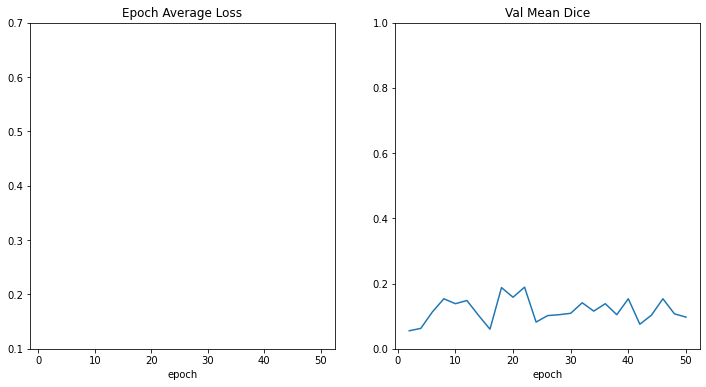

In [68]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.ylim([0.1, 0.7])
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.ylim([0, 1.0])
plt.plot(x, y)
plt.show()

# Check best model output with the input image and label


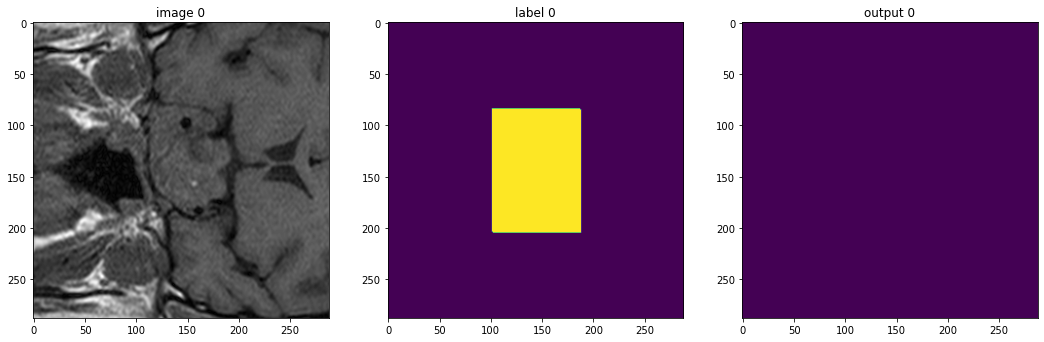

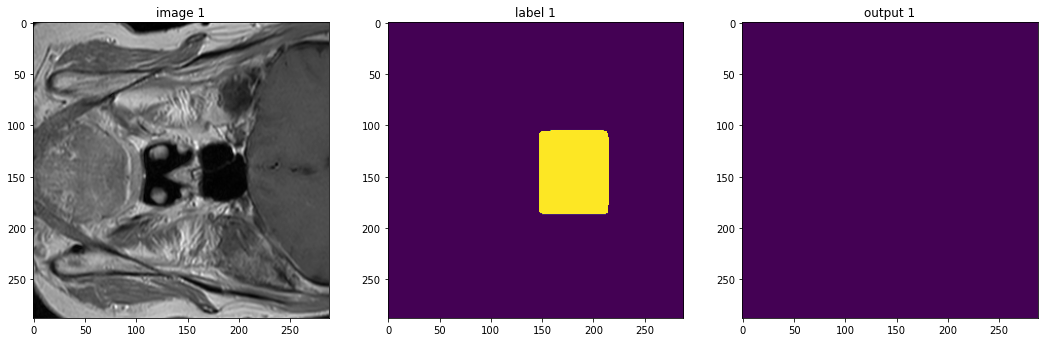

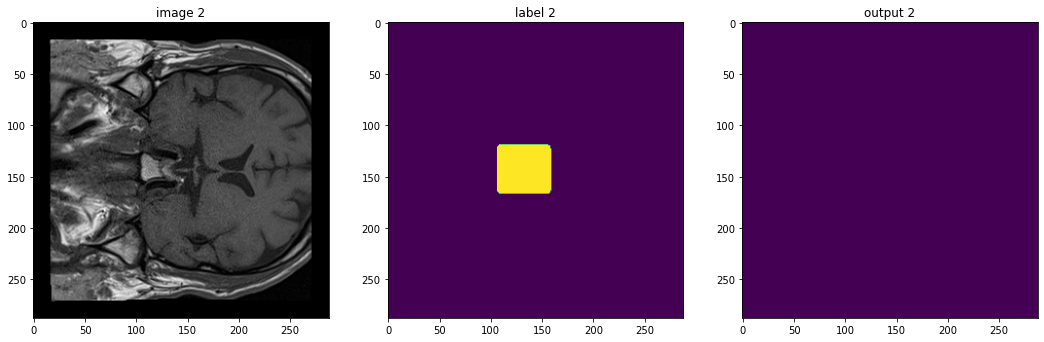

In [69]:
model.load_state_dict(torch.load(
    os.path.join(save_model_dir, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    for i, val_data in enumerate(valid_loader):
        val_inputs, val_labels = (
            val_data["im"].to(device),
            val_data["lbl"].to(device),
        )
        val_outputs = model(val_inputs)
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["im"][0, 0, :, :, center_crop_sz[2]//2], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["lbl"][0, 0, :, :, center_crop_sz[2]//2])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :, 80])
        plt.show()
        if i == 2:
            break

In [1]:
from helpers.viz import *

In [2]:
viz_compare_outputs??

In [22]:
# UNET model
model = UNet(
                    dimensions=3,
                    in_channels=1,
                    out_channels=2,
                    channels=(16, 32, 64, 128, 256),
                    strides=(2, 2, 2, 2),
                    num_res_units=2,
                    dropout=0.0,
                )

save_model_dir = "/home/gologors/data/saved_models/transfer_learning_unet/try2"


In [23]:
model.load_state_dict(torch.load(
    os.path.join(save_model_dir, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    for i, val_data in enumerate(valid_loader):
        val_inputs, val_labels = (
            val_data["im"].to(device),
            val_data["lbl"].to(device),
        )
        val_outputs = model(val_inputs)
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["im"][0, 0, :, :, center_crop_sz[2]//2], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["lbl"][0, 0, :, :, center_crop_sz[2]//2])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :, 80])
        plt.show()
        if i == 0:
            break

RuntimeError: CUDA error: all CUDA-capable devices are busy or unavailable
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
viz_compare_outputs(mr, seg, pred)